먼저 이미지를 배열화 시켜주어야 한다.

그리고 여기 이미지에서 훈련 데이터, 테스트 데이터(사실상 검증 데이터)로 나눠준다.

이후 numpy 형태로 저장.

In [1]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './binary_img_data/imgs'
categories = ['Cat', 'Dog']
np_classes = len(categories)

image_w = 64
image_h = 64

pixel = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.jpg")
#     print(idx, cat)

    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img) 
            # np.array(img) 랑 asarray(img)랑 똑같애!!
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
#             if i % 300 == 0:
#                 print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")           
X = np.array(X)
Y = np.array(y)



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./numpy_data/binary_image_data.npy", xy)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

이제 훈련을 시작한다. 저장한 numpy 값을 가지고 와서 컨볼루션 망을 구축한다.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

X_train, X_test, y_train, y_test = np.load('./numpy_data/binary_image_data.npy')
np.load = np_load_old

print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(18000, 64, 64, 3)
18000
[8987 9013]
[1013  987]


In [3]:
image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model_dir = './model'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/dog_cat_classify.model"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
__________

In [5]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Train on 15300 samples, validate on 2700 samples
Epoch 1/100
15300/15300 [==============================] - 7s 469us/step - loss: 0.6668 - acc: 0.5731 - val_loss: 0.6256 - val_acc: 0.6559

Epoch 00001: val_loss improved from inf to 0.62556, saving model to ./model/dog_cat_classify.model
Epoch 2/100
15300/15300 [==============================] - 20s 1ms/step - loss: 0.5837 - acc: 0.6844 - val_loss: 0.5587 - val_acc: 0.7152

Epoch 00002: val_loss improved from 0.62556 to 0.55872, saving model to ./model/dog_cat_classify.model
Epoch 3/100
15300/15300 [==============================] - 25s 2ms/step - loss: 0.5236 - acc: 0.7363 - val_loss: 0.5047 - val_acc: 0.7481

Epoch 00003: val_loss improved from 0.55872 to 0.50467, saving model to ./model/dog_cat_classify.model
Epoch 4/100
15300/15300 [==============================] - 26s 2ms/step - loss: 0.4948 - acc: 0.7600 - val_loss: 0.4544 - val_acc: 0.7904

Epoch 00004: val_loss improved from 0.50467 to 0.45444, saving model to ./model/dog_cat_c

In [6]:
print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

2000/2000 [==============================] - 0s 158us/step
정확도 : 0.85 


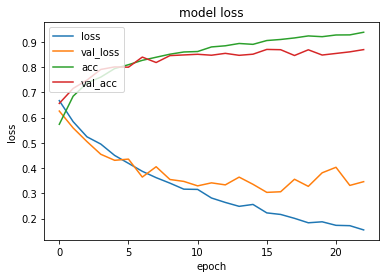

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

해당 1.jpg  이미지는 개 로 추정됩니다.
해당 2.jpg  이미지는 개 로 추정됩니다.
해당 3.jpg  이미지는 개 로 추정됩니다.
해당 4.jpg  이미지는 개 로 추정됩니다.
해당 5.jpg  이미지는 고양이 으로 추정됩니다.
해당 6.jpg  이미지는 고양이 으로 추정됩니다.
해당 7.jpg  이미지는 고양이 으로 추정됩니다.
해당 8.jpg  이미지는 개 로 추정됩니다.
해당 9.jpg  이미지는 고양이 으로 추정됩니다.
해당 10.jpg  이미지는 고양이 으로 추정됩니다.
해당 11.jpg  이미지는 고양이 으로 추정됩니다.
해당 12.jpg  이미지는 개 로 추정됩니다.
해당 13.jpg  이미지는 고양이 으로 추정됩니다.
해당 14.jpg  이미지는 고양이 으로 추정됩니다.
해당 15.jpg  이미지는 고양이 으로 추정됩니다.


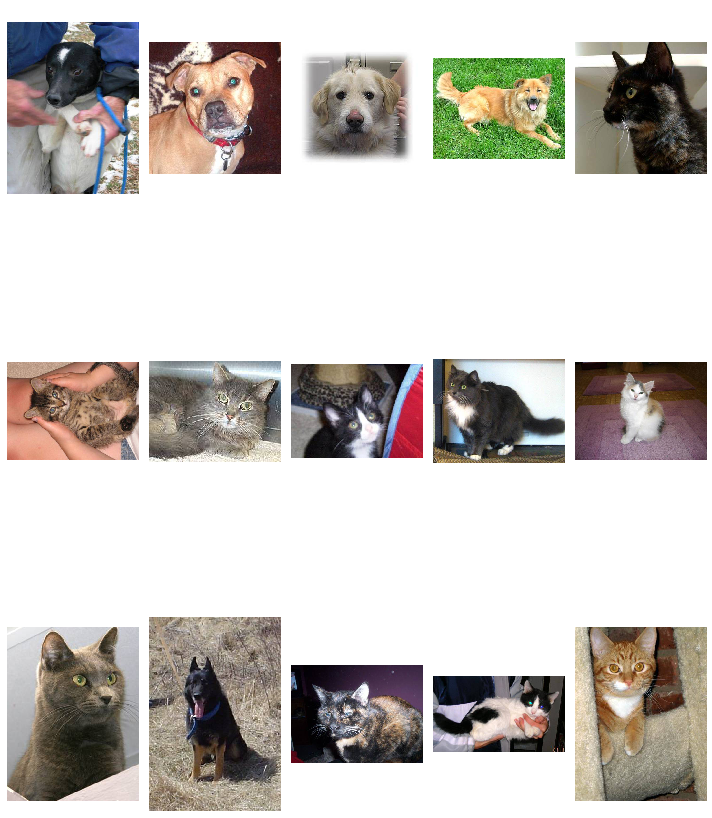

In [8]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

seed = 5
tf.set_random_seed(seed)
np.random.seed(seed)

caltech_dir = './binary_img_data/img_test'

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []

files = glob.glob(caltech_dir+"/*/*.*")

sorted_files = []
for j in files:    
    sorted_files.append(os.path.splitext(os.path.basename(j))[0])

sorted_files = map(int, sorted_files)
sorted_files = sorted(list(sorted_files))
sorted_name = []
for p in sorted_files:
    sorted_name.append(str(p) +'.jpg')

sorted_path = []
path = glob.glob(caltech_dir + '/*/')

for n in path:
    for s in sorted_name:
        sorted_path.append(n+s)   
        
filenames = []
for i, f in enumerate(sorted_path):
    
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    
    data = np.asarray(img)

    filenames.append(f)
    
    X.append(data)

X = np.array(X)
X = X.astype(float) / 255
model = load_model('./model/dog_cat_classify.model')

prediction = model.predict(X)

# np.set_printoptions -> float출력옵션 변경 print(np.array([0.12345])) -> [0.123]
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0


for i in prediction:    

# np.save 로 저장할때 0이 고양이, 1이 개 임으로 predict해서 0.5보다 크면 1에 그나마 가깝기 때문에 개, 0.5 보다 작으면 고양이로 구분하도록하는거임!!
    if i >= 0.5: 
        print("해당 " + os.path.basename(filenames[cnt]) + "  이미지는 개 로 추정됩니다.")
        
    else : 
        print("해당 " +  os.path.basename(filenames[cnt]) + "  이미지는 고양이 으로 추정됩니다.")
        

    cnt += 1

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
 
w=5
h=5
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 3
for i in range(1, columns*rows+1):
    img = plt.imread(filenames[i-1])    
    fig.add_subplot(rows, columns, i)
    plt.title(os.path.basename(filenames[i-1]))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(img)  
plt.show()

  
    
    